In [6]:
import glob, os, pandas as pd, numpy as np, matplotlib.pyplot as plt

from itertools import product

if not os.path.isdir('statistics'):
    os.mkdir('statistics')

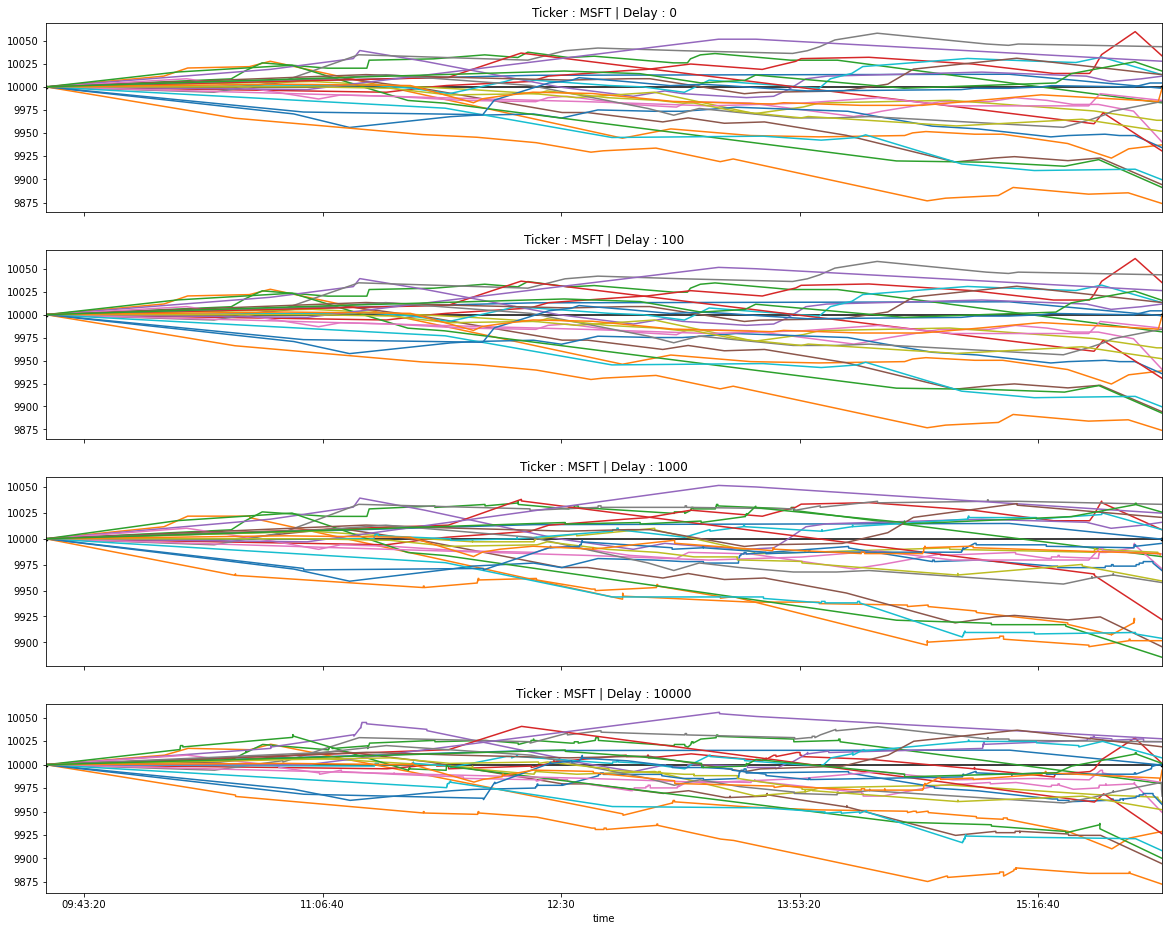

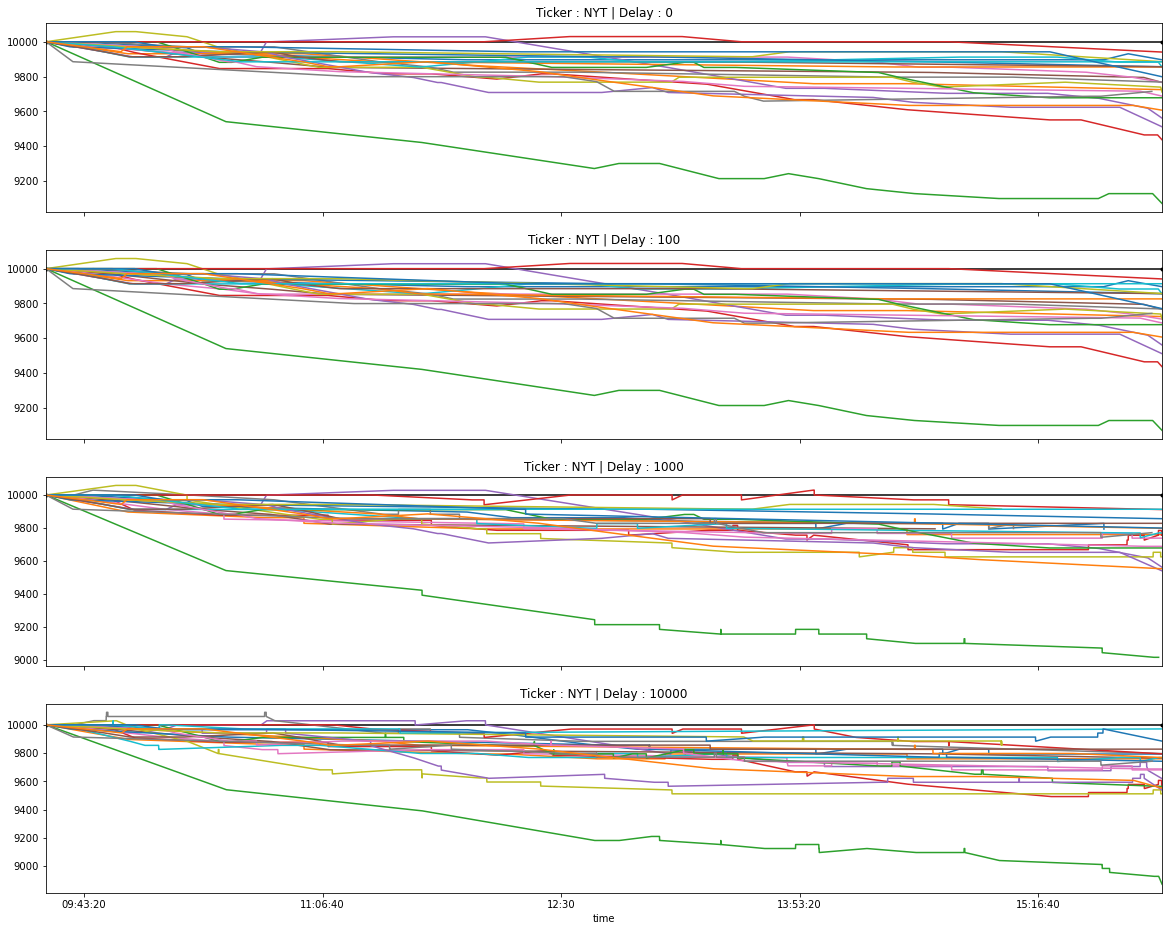

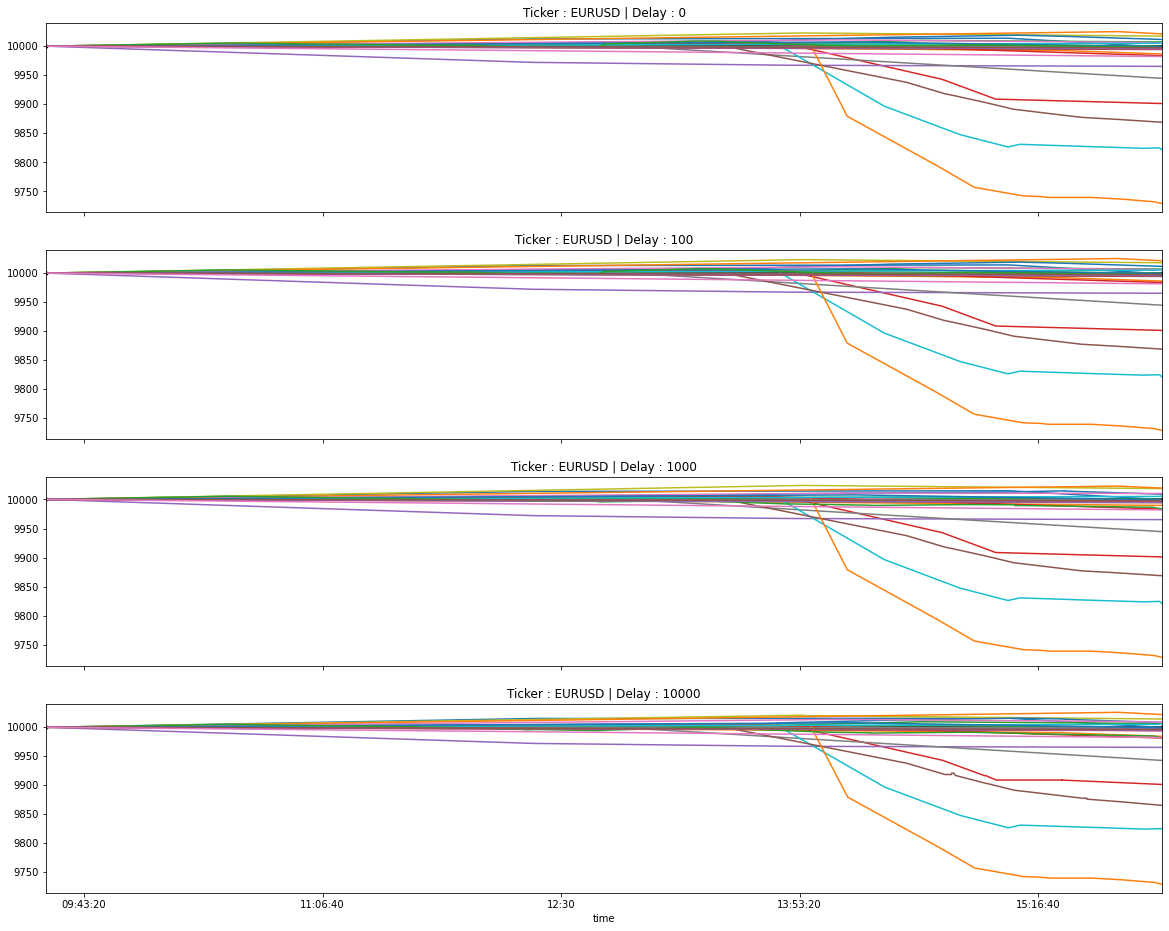

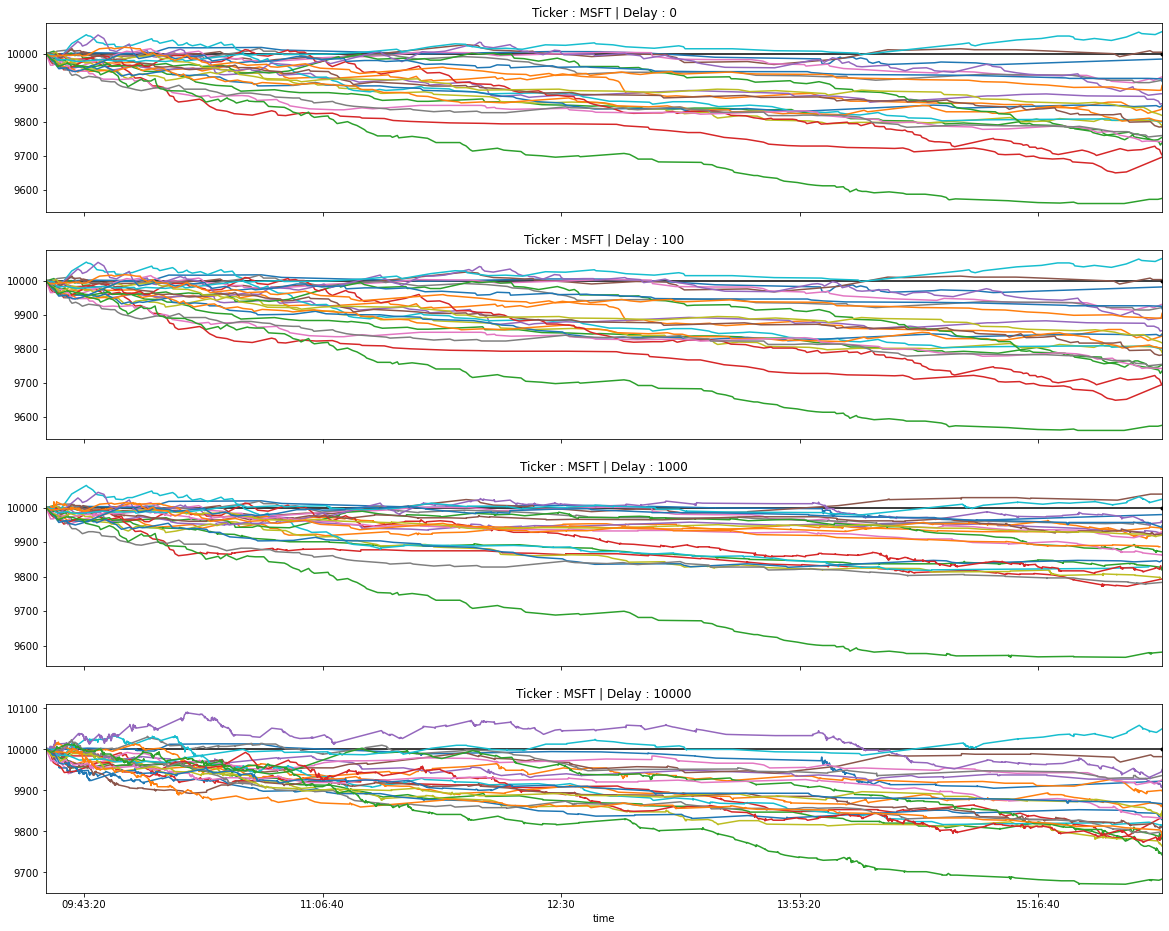

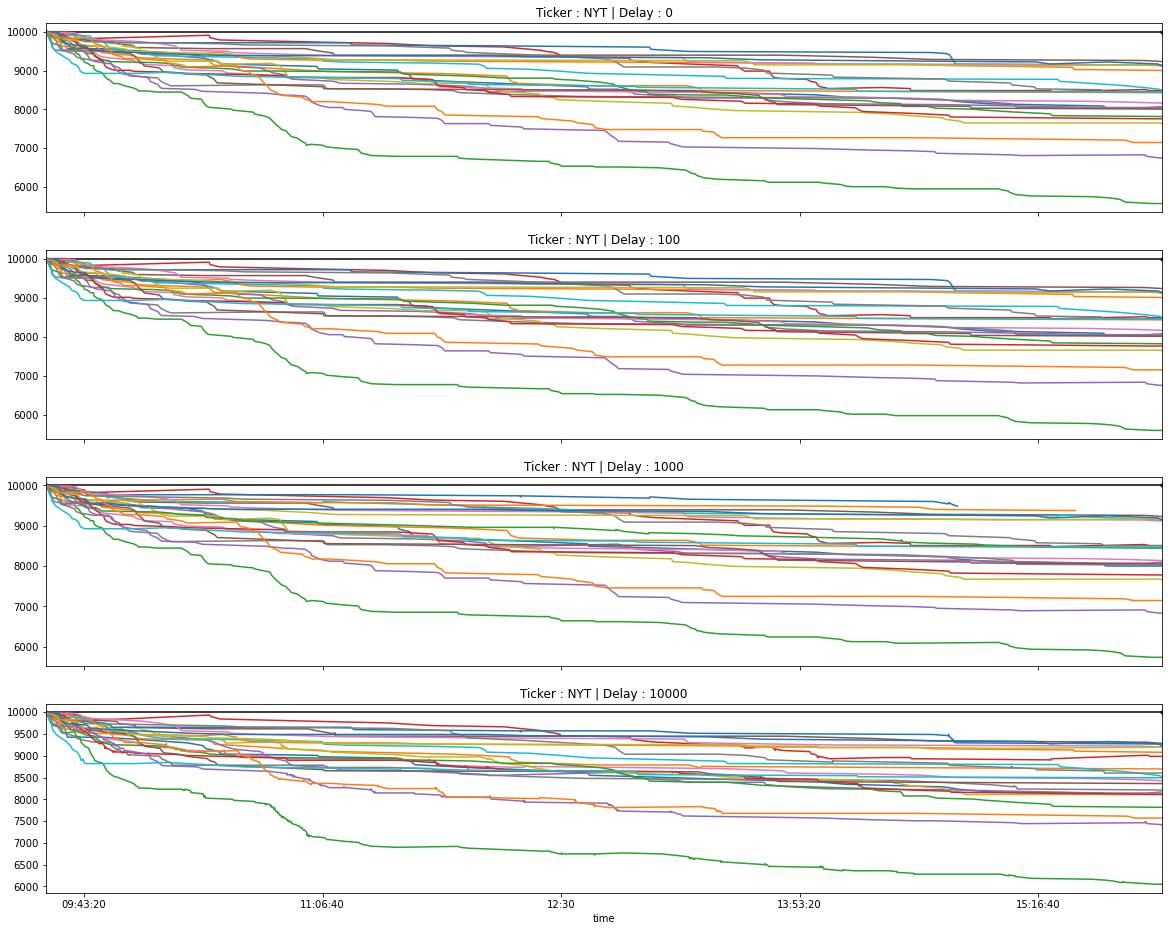

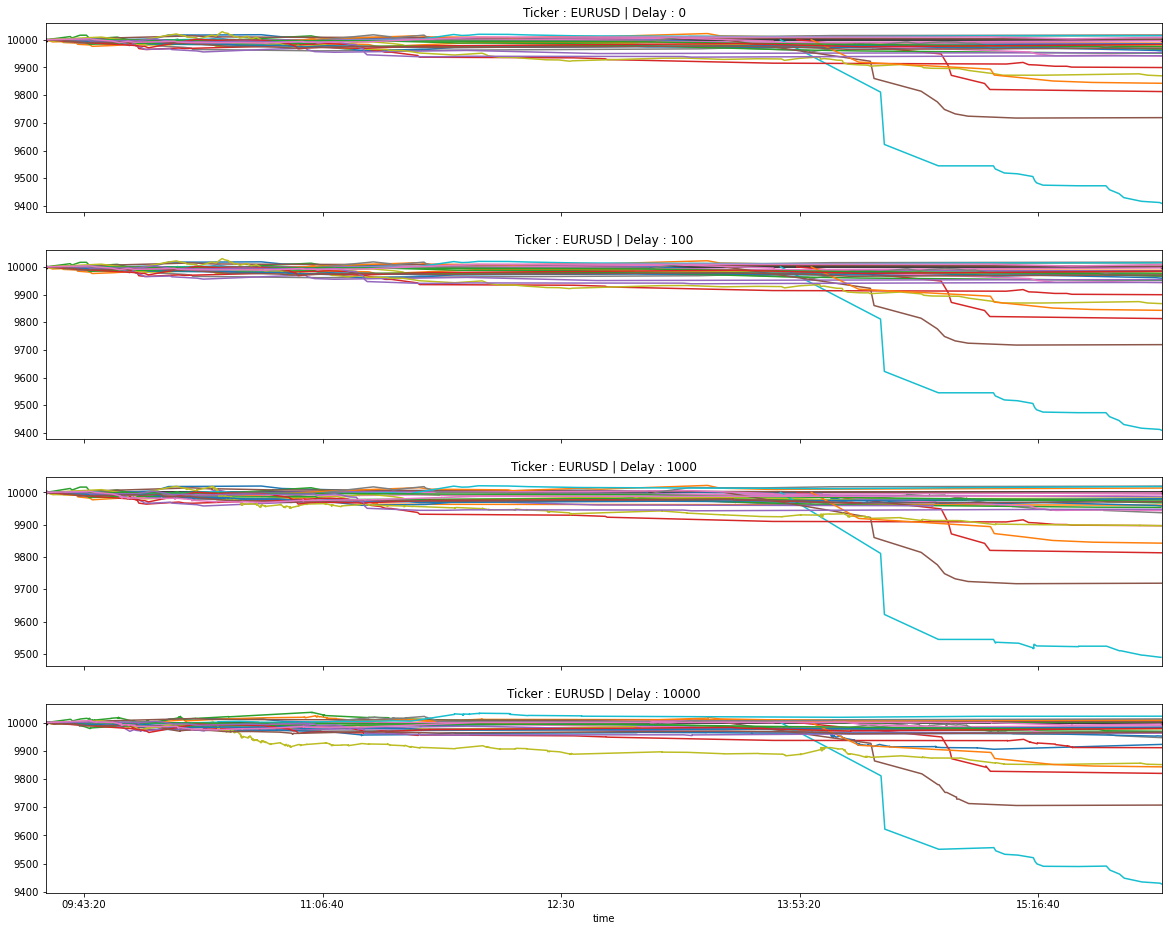

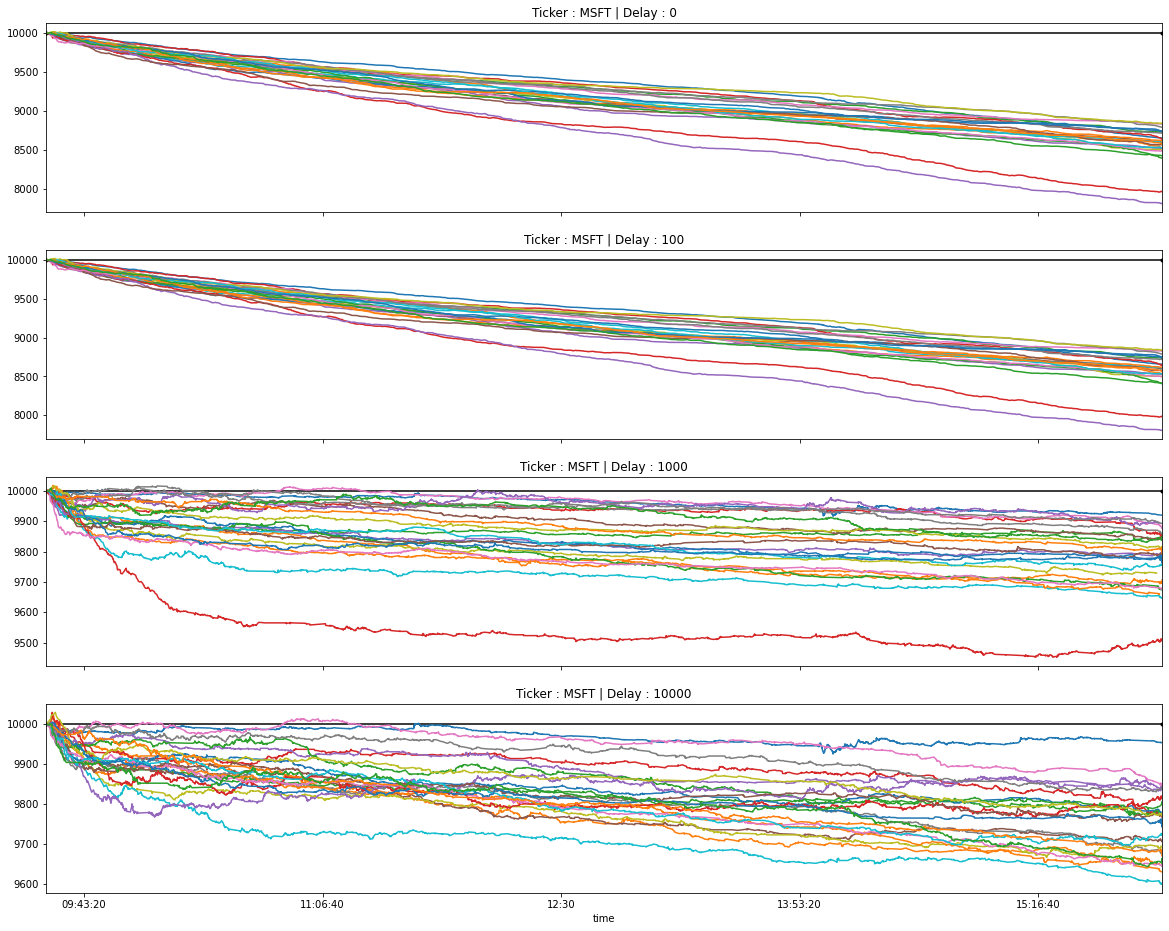

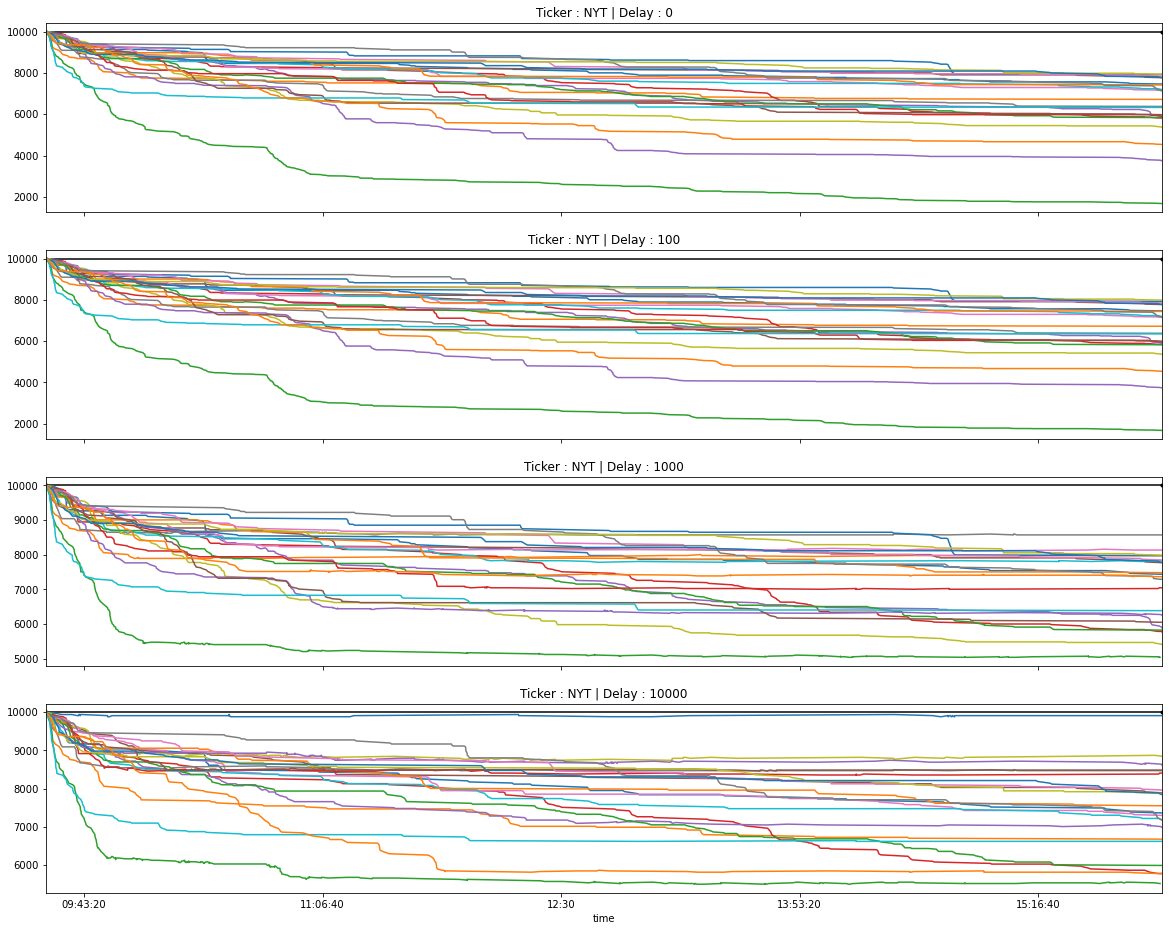

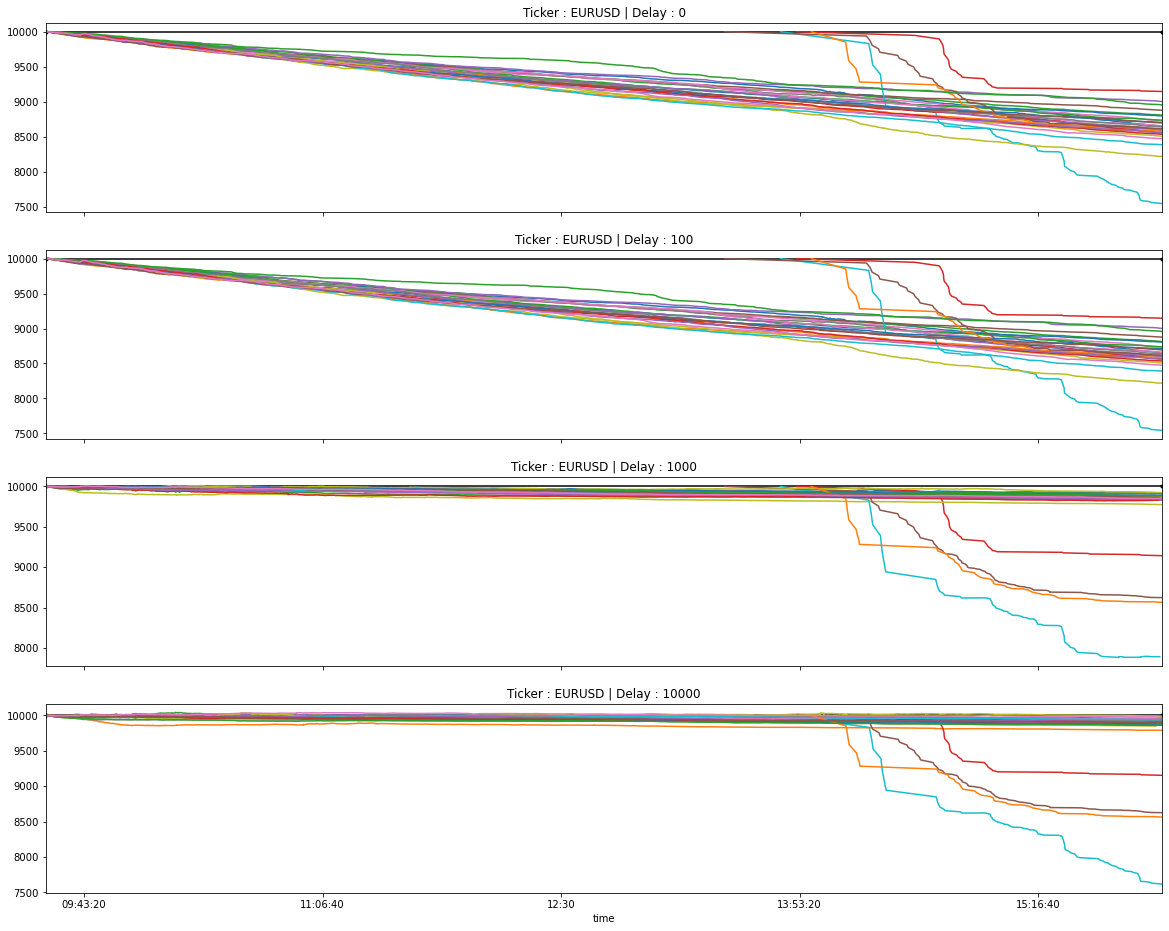

        RSI|MSFT  RSI|NYT  RSI|EURUSD  MA|MSFT  MA|NYT  MA|EURUSD  MP|MSFT  \
SIGNAL                                                                       
Sell       21326   107644        5239    53111   27999      14071   222976   
Buy        17613   101919        9212    54159   29806      12751   214609   

        MP|NYT  MP|EURUSD  
SIGNAL                     
Sell     35058     259061  
Buy      33125     252528  
       RSI|MSFT   RSI|NYT  RSI|EURUSD   MA|MSFT    MA|NYT  MA|EURUSD  \
0     -0.002912 -0.028025   -0.002891 -0.016920 -0.181739  -0.006897   
100   -0.002904 -0.028420   -0.002897 -0.016920 -0.181660  -0.006906   
1000  -0.002791  0.016038   -0.002946 -0.140282 -0.170454  -0.006787   
10000 -0.003145 -0.076389   -0.002992 -0.014676 -0.159460  -0.006916   

        MP|MSFT    MP|NYT  MP|EURUSD  
0     -0.144255 -0.364322  -0.137779  
100   -0.144154 -0.363710  -0.137822  
1000  -0.063676 -0.271812  -0.149527  
10000 -0.067175 -0.228651   0.116291  
       RSI|MSFT   R

In [80]:
strategy_names = ['RSI', 'MA', 'MP']

tickers = ['MSFT', 'NYT', 'EURUSD']

delays = [0, 100, 1000, 10000]

stats_list = []
returns_list = []
std_list = []

returns_big_list = {}

combinations = product(strategy_names, tickers)
for combination in combinations:
#     print(combination)
    (strategy, ticker) = combination
    
    # signals stats
    filenames = glob.glob('output/' + ticker + "_" + strategy + "_signals_*.csv")
    
    df_list = []
    for filename in filenames:
        df_list.append(pd.read_csv(filename))
    
    
    df_combined = pd.concat(df_list)

    df_combined['TIME'] = pd.to_datetime(df_combined['TIME']).dt.date

    stats = df_combined.groupby('SIGNAL')['TIME'].count()

    stats.name = strategy + "|" + ticker

    stats.rename(lambda x: "Sell" if x==-1 else "Buy", inplace=True)

    stats_list.append(stats)
        
    
    
    
    #tradebook stats
    filenames = glob.glob('output/' + ticker + "_" + strategy + "_tradebook_*.csv")
    
    returns = {delay : [] for delay in delays}
    
    for filename in filenames:
        tradebook = pd.read_csv(filename, index_col=0)
#         date = filename.split("_")[-1].split(".")[0]
        
        for delay in delays:
            series = tradebook['OUTSTANDING_BALANCE_' + str(delay)].dropna().sort_index(ascending=True)
            
            returns[delay] += [(series[-1] - series[0])/series[0]]
            

        
    return_series = pd.Series({delay: np.mean(returns[delay]) for delay in delays})
    return_series.name = strategy + "|" + ticker
    
    returns_list.append(return_series)
    
    std_series = pd.Series({delay: np.std(returns[delay]) for delay in delays})
    std_series.name = strategy + "|" + ticker
    
    std_list.append(std_series)
    
    
    
    
    # Plot the returns
    filenames = glob.glob('output/' + ticker + '_' + strategy + '_tradebook_*.csv')

    fig, axs = plt.subplots(nrows=len(delays), ncols=1, figsize=(20,16), sharex=True)

    for delay, ax in zip(delays, axs):
        ax.axhline(y=10000, c='black', marker='.')
        ax.set_title("Ticker : " + ticker + " | Delay : " + str(delay))

    for file in filenames:
        tradebook = pd.read_csv(file, index_col=0)
        tradebook.index = pd.to_datetime(tradebook.index).time

        for delay, ax in zip(delays, axs.flatten()):
            series_balance = tradebook["OUTSTANDING_BALANCE_" + str(delay)]
            series_inventory = tradebook["OUTSTANDING_INVENTORY_" + str(delay)]
            series_balance = series_balance[series_inventory==0]
            series_balance.sort_index(ascending=True, inplace=True)
            series_balance.plot(ax=ax)

    plt.xlim(series_balance.index[0], series_balance.index[-1])   

    plt.savefig(os.path.join('statistics', ticker + '_' + strategy + '_tradebook.jpg'))
    plt.show()   
    
    returns_big_list[(strategy, ticker)] = returns
    
      
trade_stats_combined = pd.concat(stats_list, axis=1)
returns_combined = pd.concat(returns_list, axis=1)
std_combined = pd.concat(std_list, axis=1)

print(trade_stats_combined)
print(returns_combined)
print(std_combined)

In [81]:
returns_big_list.keys()

dict_keys([('RSI', 'MSFT'), ('RSI', 'NYT'), ('RSI', 'EURUSD'), ('MA', 'MSFT'), ('MA', 'NYT'), ('MA', 'EURUSD'), ('MP', 'MSFT'), ('MP', 'NYT'), ('MP', 'EURUSD')])

In [82]:
RSI_EU_returns = returns_big_list[('RSI', 'EURUSD')]
RSI_EU_wilconsin = pd.Series(np.array([wilcoxon(RSI_EU_returns[0], RSI_EU_returns[100])[1], 
                               wilcoxon(RSI_EU_returns[0], RSI_EU_returns[1000])[1],
                               wilcoxon(RSI_EU_returns[0], RSI_EU_returns[10000])[1]]), index = [100, 1000, 10000])
RSI_EU_wilconsin.name = 'RSI_EURUSD'
RSI_EU_wilconsin

100      0.476907
1000     0.519657
10000    0.040044
Name: RSI_EURUSD, dtype: float64

In [83]:
MA_EU_returns = returns_big_list[('MA', 'EURUSD')]
MA_EU_wilconsin = pd.Series(np.array([wilcoxon(MA_EU_returns[0], MA_EU_returns[100])[1], 
                               wilcoxon(MA_EU_returns[0], MA_EU_returns[1000])[1],
                               wilcoxon(MA_EU_returns[0], MA_EU_returns[10000])[1]]), index = [100, 1000, 10000])
MA_EU_wilconsin.name = 'MA_EURUSD'
MA_EU_wilconsin

100      0.573169
1000     0.909011
10000    0.848929
Name: MA_EURUSD, dtype: float64

In [84]:
MP_EU_returns = returns_big_list[('MP', 'EURUSD')]
MP_EU_wilconsin = pd.Series(np.array([wilcoxon(MP_EU_returns[0], MP_EU_returns[100])[1], 
                               wilcoxon(MP_EU_returns[0], MP_EU_returns[1000])[1],
                               wilcoxon(MP_EU_returns[0], MP_EU_returns[10000])[1]]), index = [100, 1000, 10000])
MP_EU_wilconsin.name = 'MA_EURUSD'
MP_EU_wilconsin

100      0.475825
1000     0.239106
10000    0.000008
Name: MA_EURUSD, dtype: float64

In [39]:
RSI_MSFT_returns = returns_big_list[('RSI', 'MSFT')]
# RSI_MSFT_returns

In [58]:
[wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[100])[1], 
         wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[1000])[1], 
         wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[10000])[1]]

[0.6744240722352938, 0.9168474674224854, 0.3446848392486572]

In [55]:
np.array([wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[100])[1], 
         wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[1000][1]), 
         wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[10000][1])])

TypeError: len() of unsized object

In [64]:
from scipy.stats import wilcoxon
RSI_MSFT_wilconsin = pd.Series(np.array([wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[100])[1], 
                               wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[1000])[1],
                               wilcoxon(RSI_MSFT_returns[0], RSI_MSFT_returns[10000])[1]]), index = [100, 1000, 10000])
RSI_MSFT_wilconsin.name = 'RSI_MSFT'
RSI_MSFT_wilconsin

100      0.674424
1000     0.916847
10000    0.344685
Name: RSI_MSFT, dtype: float64

In [65]:
RSI_NYT_returns = returns_big_list[('RSI', 'NYT')]
RSI_NYT_wilconsin = pd.Series(np.array([wilcoxon(RSI_NYT_returns[0], RSI_NYT_returns[100])[1], 
                               wilcoxon(RSI_NYT_returns[0], RSI_NYT_returns[1000])[1],
                               wilcoxon(RSI_NYT_returns[0], RSI_NYT_returns[10000])[1]]), index = [100, 1000, 10000])
RSI_NYT_wilconsin.name = 'RSI_NYT'
RSI_NYT_wilconsin

100      0.248864
1000     0.747500
10000    0.063419
Name: RSI_NYT, dtype: float64

In [67]:
MA_MSFT_returns = returns_big_list[('MA', 'MSFT')]
MA_MSFT_wilconsin = pd.Series(np.array([wilcoxon(MA_MSFT_returns[0], MA_MSFT_returns[100])[1], 
                               wilcoxon(MA_MSFT_returns[0], MA_MSFT_returns[1000])[1],
                               wilcoxon(MA_MSFT_returns[0], MA_MSFT_returns[10000])[1]]), index = [100, 1000, 10000])
MA_MSFT_wilconsin.name = 'MA_MSFT'
MA_MSFT_wilconsin

100      0.940481
1000     0.211178
10000    0.080203
Name: MA_MSFT, dtype: float64

In [68]:
MA_NYT_returns = returns_big_list[('MA', 'NYT')]
MA_NYT_wilconsin = pd.Series(np.array([wilcoxon(MA_NYT_returns[0], MA_NYT_returns[100])[1], 
                               wilcoxon(MA_NYT_returns[0], MA_NYT_returns[1000])[1],
                               wilcoxon(MA_NYT_returns[0], MA_NYT_returns[10000])[1]]), index = [100, 1000, 10000])
MA_NYT_wilconsin.name = 'MA_NYT'
MA_NYT_wilconsin

100      3.173105e-01
1000     1.284706e-03
10000    4.768372e-07
Name: MA_NYT, dtype: float64

In [69]:
MP_MSFT_returns = returns_big_list[('MP', 'MSFT')]
MP_MSFT_wilconsin = pd.Series(np.array([wilcoxon(MP_MSFT_returns[0], MP_MSFT_returns[100])[1], 
                               wilcoxon(MP_MSFT_returns[0], MP_MSFT_returns[1000])[1],
                               wilcoxon(MP_MSFT_returns[0], MP_MSFT_returns[10000])[1]]), index = [100, 1000, 10000])
MP_MSFT_wilconsin.name = 'MP_MSFT'
MP_MSFT_wilconsin

100      0.559958
1000     0.016311
10000    0.000153
Name: MP_MSFT, dtype: float64

In [70]:
MP_NYT_returns = returns_big_list[('MP', 'NYT')]
MP_NYT_wilconsin = pd.Series(np.array([wilcoxon(MP_NYT_returns[0], MP_NYT_returns[100])[1], 
                               wilcoxon(MP_NYT_returns[0], MP_NYT_returns[1000])[1],
                               wilcoxon(MP_NYT_returns[0], MP_NYT_returns[10000])[1]]), index = [100, 1000, 10000])
MP_NYT_wilconsin.name = 'MP_NYT'
MP_NYT_wilconsin

100      0.130665
1000     0.000618
10000    0.000177
Name: MP_NYT, dtype: float64

In [85]:
wisconsin_test = pd.concat([RSI_MSFT_wilconsin, RSI_NYT_wilconsin, RSI_EU_wilconsin, MA_MSFT_wilconsin, MA_NYT_wilconsin, MA_EU_wilconsin, MP_MSFT_wilconsin, MP_NYT_wilconsin, MP_EU_wilconsin], axis = 1).round(3)
wisconsin_test.index.name = 'Delay (ms)'
wisconsin_test

,RSI_MSFT,RSI_NYT,RSI_EURUSD,MA_MSFT,MA_NYT,MA_EURUSD,MP_MSFT,MP_NYT,MA_EURUSD
Delay (ms),,,,,,,,,
100,0.674,0.249,0.477,0.940,0.317,0.573,0.560,0.131,0.476
1000,0.917,0.748,0.520,0.211,0.001,0.909,0.016,0.001,0.239
10000,0.345,0.063,0.040,0.080,0.000,0.849,0.000,0.000,0.000


In [62]:
returns_big_list.keys()

dict_keys([('RSI', 'MSFT'), ('RSI', 'NYT'), ('MA', 'MSFT'), ('MA', 'NYT'), ('MP', 'MSFT'), ('MP', 'NYT')])

In [3]:
trade_stats_combined.plot.bar(figsize=(20,12))

plt.title('Number of signals')
# plt.xlabel('Buy/Sell')
# plt.ylabel('Returns')

plt.savefig(os.path.join('statistics', 'number_of_signals_bar.jpg'), format='jpeg')




NameError: name 'trade_stats_combined' is not defined

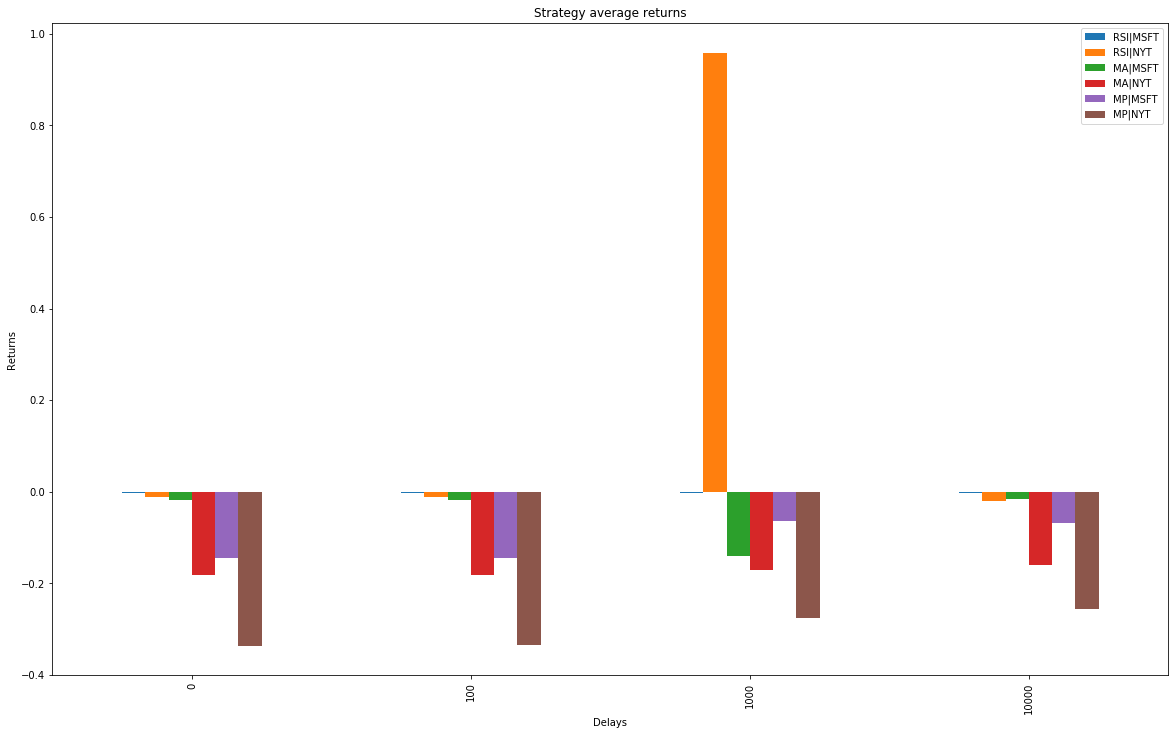

In [10]:
returns_combined.plot.bar(figsize=(20,12))

plt.title('Strategy average returns')
plt.xlabel('Delays')
plt.ylabel('Returns')

plt.savefig(os.path.join('statistics', 'strategy_returns_bar.jpg'), format='jpeg')



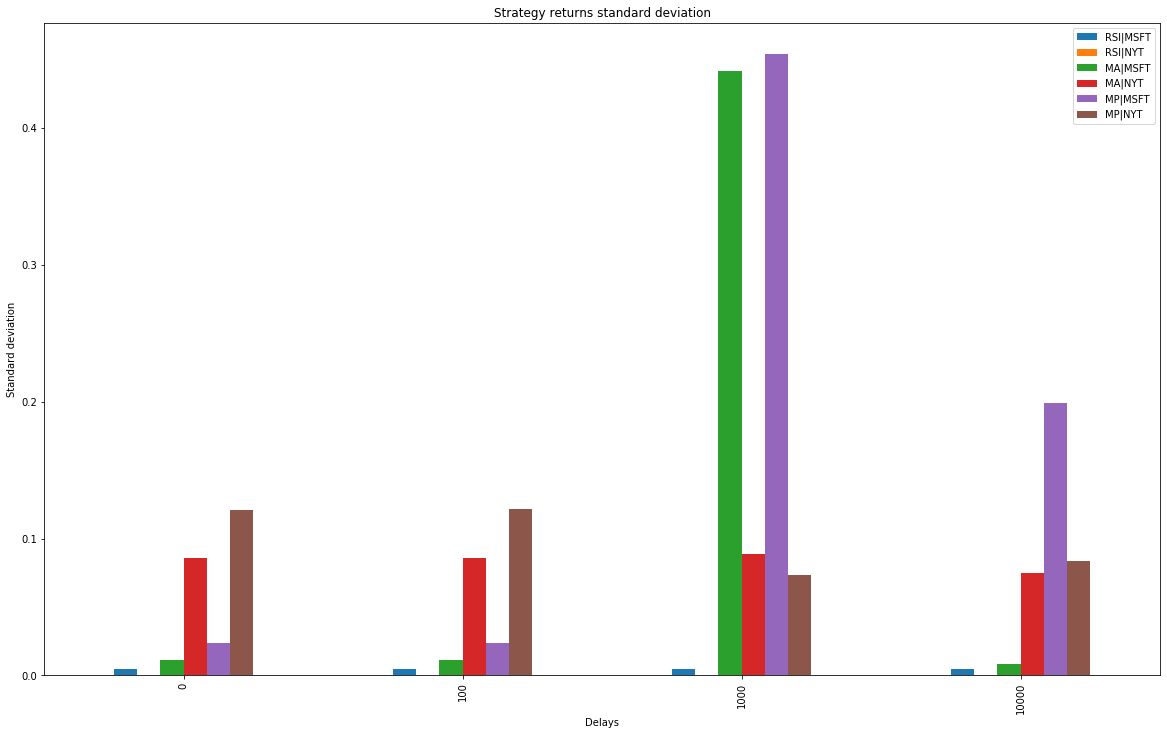

In [11]:
std_combined.plot.bar(figsize=(20,12))

plt.title('Strategy returns standard deviation')
plt.xlabel('Delays')
plt.ylabel('Standard deviation')

plt.savefig(os.path.join('statistics', 'strategy_std_bar.jpg'), format='jpeg')


